In [37]:
!pip install PyKomoran

In [38]:
# font 설정

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm._rebuild()
plt.rc('font', family='NanumGothic')

for fontInfo in fm.fontManager.ttflist:
    if 'Nanum' in fontInfo.name:
        print(fontInfo.name+" = "+fontInfo.fname)

NanumGothicCoding = /usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothic.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf
Nanum Pen Script = /usr/share/fonts/truetype/nanum/NanumPen.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothicLight.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
NanumBarunpen = /usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
Nanum Brush Script = /usr/share/fonts/truetype/nanum/NanumBrush.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundEB.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
NanumBarunGothic 

In [39]:
import pandas as pd
import numpy as np

from pprint import pprint

from wordcloud import WordCloud
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import nltk

from PyKomoran import *

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
pro_file = pd.read_excel('/content/drive/MyDrive/AI_bootcamp/기업 협업 프로젝트/M_-__.xlsx')
#pro_file = pd.read_excel('/content/Co_data.xlsx?dl=0')

In [49]:
dicpath = '/content/drive/MyDrive/AI_bootcamp/기업 협업 프로젝트/my_dict.txt' # 텍스트 파일주소로, 사용자 사전의 구조는 위와 같습니다.
komoran = Komoran("STABLE")
komoran.set_user_dic(dicpath)

In [50]:
# 불용어
stop_pos_tags =  ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH', 
                   'SW', 'NF', 'NV', 'SN', 'NA']
custom_stopwords = ['시','하','고','이다','이요','어','하다','었','어요','아','것','님','있',
                    '았','게','저','잘','지','다','푹','러','겠']

In [58]:
# 어미 복원 & 토큰화
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.get_list(corpus)
    for pair in pairs:
        morph = pair.get_first()
        pos = pair.get_second()
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    result_stopwords = []
    for x in result:
      if x not in custom_stopwords:
        result_stopwords.append(x)

    return result_stopwords

In [61]:
# 명사만 추출
def get_nouns(corpus, stop_pos_tags):
    result = []
    pairs = komoran.get_nouns(corpus)
    for pair in pairs:
        if pair not in stop_pos_tags:
            result.append(pair)
    result_stopwords = []
    for x in result:
      if x not in custom_stopwords:
        result_stopwords.append(x)

    return result_stopwords

In [62]:
# 가중치 조절 없이 퓨어 한 것
def pure_summarize(df,debug_mode='off',nouns='off'):
  # 한글만
  df = df.loc[:,['회원 코드','대화 내용']]
  df.columns = ['code','text']
  df.dropna(inplace=True)
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

  # 참여했습니다가 있는 행 제거
  token_list = []
  for x in df['text']:
    if '참여했습니다' in x :
      token_list.append(None)
    else:
      token_list.append(x)

  df['text']=token_list
  df.dropna(inplace=True)
  df.reset_index(drop=True,inplace=True)
  
  # 토큰화
  tokens_list = []

  for i in range(len(df['text'])):
    try:
      if nouns == 'off':
        tokens_list.append(tokenize(df['text'][i], stop_pos_tags))
      elif nouns == 'on':
        tokens_list.append(get_nouns(df['text'][i], stop_pos_tags))
      else:
        print("명사 사용의 on/off를 제대로 작성해주세요.")
    except:
      tokens_list.append([])

  df['tokens'] = tokens_list

  # 최대 빈도 단어 추출
  tokens = [t for d in df['tokens'] for t in d]
  text = nltk.Text(tokens, name='NMSC')

  # 디버그 모드 시, 워드 클라우드 사용 x
  if debug_mode == 'on':
    pprint(text.vocab().most_common(20))
    return

  else:       
    keyword_list = [x[0] for x in text.vocab().most_common(5)]
    #print(keyword_list)

    c = Counter(tokens)
    wc = WordCloud(font_path='NanumGothic', width=2000, height=2000, scale=0.5, max_font_size=500)
    gen = wc.generate_from_frequencies(c)
    plt.figure(figsize=(12,12))
    plt.imshow(gen)
    plt.axis('off')
    plt.show()
    return keyword_list

In [63]:
# 한 사람이 출현(?)한 횟수로 나눔.
def num_bal_summarize(df,debug_mode='off',nouns='off'):
  df = df.loc[:,['회원 코드','대화 내용']]
  df.columns = ['code','text']
  df.dropna(inplace=True)
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글만

  # 참여했습니다가 있는 행 제거
  token_list = []
  for x in df['text']:
    if '참여했습니다' in x :
      token_list.append(None)
    else:
      token_list.append(x)

  df['text']=token_list
  df.dropna(inplace=True)
  df.reset_index(drop=True,inplace=True)
  
  # 토큰화
  tokens_list = []

  for i in range(len(df['text'])):
    try:
      if nouns=='off':
        tokens_list.append(tokenize(df['text'][i], stop_pos_tags))
      elif nouns=='on':
        tokens_list.append(get_nouns(df['text'][i], stop_pos_tags))
      else:
        print("명사 사용의 on/off를 제대로 작성해주세요.")
    except:
      tokens_list.append([])

  df['tokens'] = tokens_list

  # 최대 빈도 단어 추출
  #tokens = [t for d in df['tokens'] for t in d]

  test_bal_df = df

  abc = pd.DataFrame(test_bal_df['code'].value_counts())
  abc.reset_index(inplace=True)
  abc.columns=['code','counts']

  sum_dict = dict()
  tokens = []

  for code,num in zip(abc['code'], abc['counts']):
    test_dict = dict()
    bbcd = test_bal_df[test_bal_df['code']==code]
    token = [t for d in bbcd['tokens'] for t in d]
    tokens.extend(token)
    c = Counter(tokens)
    for x , y in zip(c.keys(), c.values()):
      test_dict[x] = y/num
    sum_dict = Counter(sum_dict) + Counter(test_dict)

  text = nltk.Text(tokens, name='NMSC')

  # 디버그 모드 시, 워드 클라우드 사용 x
  if debug_mode == 'on':
    pprint(text.vocab().most_common(20))
    return

  else: 
    keyword_list = [x[0] for x in text.vocab().most_common(5)]
    #print(keyword_list)

    wc = WordCloud(font_path='NanumGothic', width=2000, height=2000, scale=0.5, max_font_size=500)
    gen = wc.generate_from_frequencies(sum_dict)
    plt.figure(figsize=(12,12))
    plt.imshow(gen)
    plt.axis('off')
    plt.show()
    return keyword_list

In [67]:
pro_file[3668:3698]

,날짜,시간,회원 코드,대화 내용,"파일(영상, 음성), 사진 여부"
3668,NaN,12:55,WKDG,Operator저는 점심 쌀국수 먹을거예요! 지금 주문했다는~,NaN
3669,NaN,12:56,ORNS,맛있게 드세요 ㅎ 점심먹고 잤더니 컨디션 좋네요,NaN
3670,NaN,12:56,FLPX,근데 기분은 좋네요 히히! 저는 오랜만에 여가생활을 보내고 있어요!,NaN
3671,NaN,12:56,EZUK,저는 쌈밥을 만들어 먹어보았읍니다.\n즐거운 점심시간 되셔요,NaN
3672,NaN,12:59,FLPX,아까 슈퍼가서 간단한 술과 간식거리 사와서 집에서 암막커튼+에어컨+영화를 켜놓고 집...,NaN
3673,NaN,12:59,JJYL,오....쌀국수...거의 안먹어보긴했지만,NaN
3674,NaN,12:59,JJYL,면이 들어간거라면 거의다 맛있죠!!,NaN
3675,NaN,12:59,PHSG,맛있게 드셔용~~~,NaN
3676,NaN,13:00,FLPX,알피님은 오늘 무엇을 하실 예정이신가요!,NaN
3677,NaN,13:02,FLPX,호오! 알피님도 여유생활이시군요! 좋아요!👍,NaN


In [70]:
# 가중치 조절 없는 퓨어 단어 요약
pure_summarize(pro_file[3669:3698],nouns='on',debug_mode='on')

[('알피', 6),
 ('쌀국수', 4),
 ('택배', 3),
 ('문제', 3),
 ('점심', 2),
 ('생활', 2),
 ('오', 2),
 ('배송', 2),
 ('요즘', 2),
 ('오후', 2),
 ('컨디션', 1),
 ('기분', 1),
 ('오랜만', 1),
 ('여가', 1),
 ('쌈밥', 1),
 ('점심시간', 1),
 ('슈퍼', 1),
 ('서', 1),
 ('술', 1),
 ('간식거리', 1)]


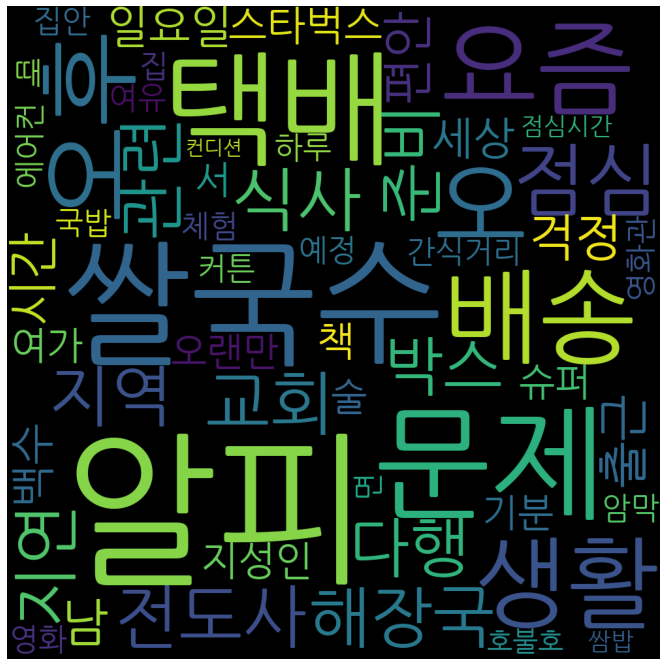

['알피', '쌀국수', '택배', '문제', '배송']

In [69]:
# 가중치 조절 단어 요약
num_bal_summarize(pro_file[3669:3698],nouns='on')